# Medical image analysis based on GMM

we will apply GMM to find the distribution of colors in medical images.

In [64]:
import os
import scipy
from PIL import Image
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [65]:
# https://www.kaggle.com/datasets/saife245/tuberculosis-image-datasets
path_to_download = "data/MED"

## Parse data

In [66]:
def load_jpg(path):
    image = Image.open(path)
    return np.array(image)
def load_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()
    # Accessing object details
    
    data = []
    for obj in root.findall("object"):
        label = obj.find("label").text
        pose = obj.find("pose").text
        truncated = obj.find("truncated").text
        occluded = obj.find("occluded").text
        
        # Access bounding box details
        bndbox = obj.find("bndbox")
        xmin = bndbox.find("xmin").text
        ymin = bndbox.find("ymin").text
        xmax = bndbox.find("xmax").text
        ymax = bndbox.find("ymax").text
    
        data.append((xmin,xmax,ymin,ymax, label))
    return data
def get_data(path):
    file_names = os.listdir(path)
    data_jpg = {}
    data_xml = {}
    for file_name in file_names:
        file_path = os.path.join(path, file_name)
        file_without_ext = file_name.split('.')[0]
        if file_name.endswith(".jpg"):
            data_jpg[file_without_ext] = load_jpg(file_path)
        
        if file_name.endswith(".xml"):
            data_xml[file_without_ext] = load_xml(file_path)
        assert True, "Not supported format found in the directory"
    
    keys = list(data_jpg.keys())
    x = []
    y = []
    for key in keys:
        x.append(data_jpg[key])
        y.append(data_xml[key])
    return x, y, keys
    
    
x,y, file_name = get_data(path_to_download)
x = np.array(x)

In [67]:
x_pixel = x.reshape(-1,3)

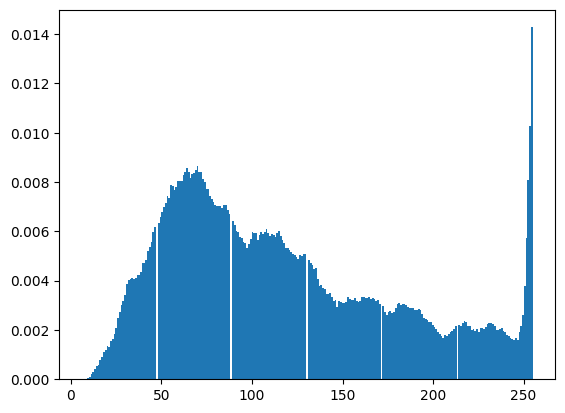

In [68]:
nb_data_considered= 1000000
plt.hist(x_pixel[:nb_data_considered,0], bins=255, density=True)
plt.show()

## GMM tests

In [69]:
from GMMs import GMM

model = GMM(20)

model.fit(x_pixel[:int(1e6)], verbose=True)

0.0% fit
1.0% fit
4.0% fit
9.0% fit


(1224, 1632, 3)


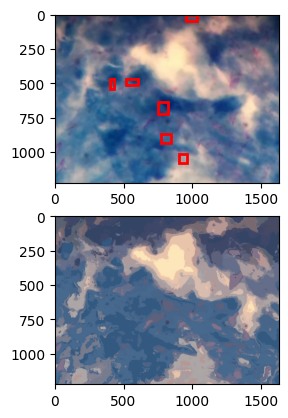

In [70]:
def transform_img(img, trained_model):
    img_shape = img.shape
    img_pixeled = img.reshape(-1,3)
    classes = trained_model.predict(img_pixeled)
    predicted_pixeled = trained_model.means_[classes]
    img_pred = predicted_pixeled.reshape(img_shape)
    return img_pred

def add_labels(boxes, ax):
    for box in boxes:
        xmin,xmax,ymin,ymax, _ = box
        xmin,xmax,ymin,ymax = int(xmin),int(xmax),int(ymin),int(ymax)
        rectangle = patches.Rectangle((ymin, xmin), ymax - ymin, xmax - xmin,
                         linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rectangle)
        
        
img_0 = x[0]
result = transform_img(img_0, model)
result = np.rint(result).astype(np.uint8)
fix,ax = plt.subplots(2,1)
add_labels(y[0], ax[0])
ax[0].imshow(img_0)
ax[1].imshow(result)
print(img_0.shape)
    

638 723 750 825
872 936 773 847
1285 1340 705 798
1555 1617 690 752
467 541 404 434
0 46 955 1037
1018 1080 903 963
1499 1553 1138 1200
471 513 515 604


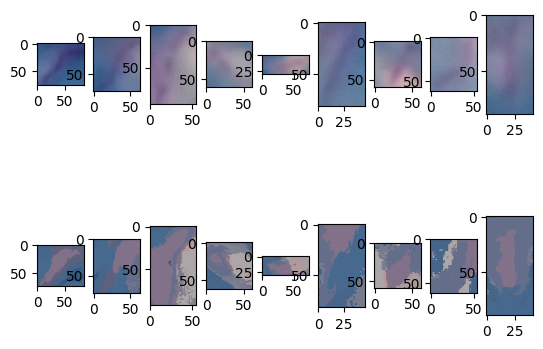

In [71]:
img_0 = x[0]
result = transform_img(img_0, model)
result = np.rint(result).astype(np.uint8)
nb_box = len(y[0])
fix,ax = plt.subplots(2,nb_box)
for k,box in enumerate(y[0]):
    xmin,xmax,ymin,ymax, _ = box
    xmin,xmax,ymin,ymax = int(xmin),int(xmax),int(ymin),int(ymax)
    print(xmin,xmax,ymin,ymax)
    ax[0][k].imshow(img_0[ymin:ymax, xmin:xmax])
    ax[1][k].imshow(result[ymin:ymax, xmin:xmax])
    

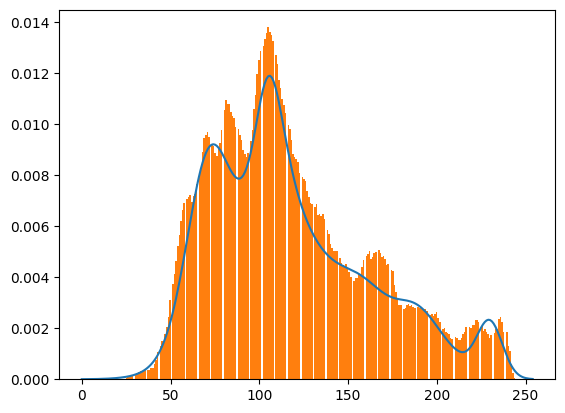

In [73]:

def marginal_density(gmm_means, gmm_covs, gmm_probs, dim_to_keep, points):
    """
    Compute the marginal density of the GMM
    """
    density_values = np.zeros(len(points))
    
    for mean, cov, prob in zip(gmm_means, gmm_covs, gmm_probs):
        mean_marginal = mean[dim_to_keep]
        cov_marginal = cov[np.ix_(dim_to_keep, dim_to_keep)]
        
        marginal_gaussian = scipy.stats.multivariate_normal(mean=mean_marginal, cov=cov_marginal)
        
        # Compute the density for each component
        density_values += prob * marginal_gaussian.pdf(points)
    
    return density_values


density = marginal_density(model.means_, model.covariances_, model.weights_, [1], np.arange(255))
fix,ax = plt.subplots(1,1)
ax.plot(density)
ax.hist(x_pixel[:nb_data_considered,1], bins=255, density=True)
plt.show()